In [1]:
# project: p6
# submitter: kkhill4
# partner: none
# hours: 20

In [2]:
# imports
import geopandas
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np
from matplotlib.colors import ListedColormap
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [3]:
#Q1
counties = geopandas.read_file("counties.geojson")
len(counties)

72

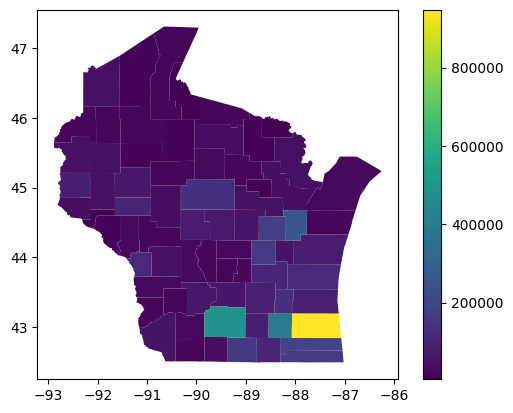

In [4]:
#Q2
ax = counties.plot(column = "POP100", legend = True)

In [5]:
conn = sqlite3.connect("counties_tracts.db")
pd.read_sql("""SELECT * FROM sqlite_master""", conn)

,type,name,tbl_name,rootpage,sql
0,table,counties,counties,2,"CREATE TABLE ""counties"" (\n""index"" INTEGER,\n ..."
1,index,ix_counties_index,counties,3,"CREATE INDEX ""ix_counties_index""ON ""counties"" ..."
2,table,tracts,tracts,4,"CREATE TABLE ""tracts"" (\n""index"" INTEGER,\n ""..."
3,index,ix_tracts_index,tracts,5,"CREATE INDEX ""ix_tracts_index""ON ""tracts"" (""in..."


In [6]:
#Q3
counties["AREALAND"] = pd.read_sql("SELECT * FROM counties", conn)["AREALAND"]
train, test = train_test_split(counties, random_state = 250, test_size = 0.25)
arealand = test["NAME"].tolist()
arealand

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [7]:
#Q4
model = LinearRegression()
model.fit(train[["AREALAND"]], train["POP100"])
model.score(test[["AREALAND"]], test["POP100"])

0.016720430179409274

In [8]:
#Q5
area = 400 * 2.59 * 1000000
predict_df = pd.DataFrame({"AREALAND": [area]})
predicted_y = model.predict(predict_df[['AREALAND']])
predict_df["predicted_y"] = predicted_y[0]
predicted_pop = predict_df.iloc[0, 1]
predicted_pop

90000.07422783462

In [9]:
#Q6
HU100_query = pd.read_sql("""SELECT SUM(tracts.HU100) as HU100, counties.NAME FROM tracts LEFT JOIN counties ON tracts.COUNTY = counties.COUNTY GROUP BY counties.NAME""", conn)
merged_df = pd.merge(counties, HU100_query, how = "inner", on = "NAME")
train, test = train_test_split(merged_df, random_state = 250, test_size = 0.25)
test_counties = test["NAME"].tolist()
test_counties

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [10]:
#Q7
HU100_vals = test.set_index("NAME").to_dict()['HU100']
HU100_vals

{'Dane County': 216022,
 'Juneau County': 14669,
 'Taylor County': 10582,
 'Vilas County': 25116,
 'Rusk County': 8883,
 'Price County': 11120,
 'Jackson County': 9727,
 'Waushara County': 14843,
 'Pepin County': 3579,
 'Douglas County': 22825,
 'Ashland County': 9656,
 'Milwaukee County': 418053,
 'Waupaca County': 25396,
 'Richland County': 8868,
 'Lafayette County': 7230,
 'Washburn County': 12979,
 'Dunn County': 17964,
 'Bayfield County': 12999}

In [11]:
#Q8
cross_val_score(model, train[["HU100"]], train["POP100"], cv = 5).mean()

0.9739348181232653

In [12]:
#Q9
cross_val_score(model, train[["HU100"]], train["POP100"], cv = 5).std()

0.01693954236334351

In [13]:
#Q10
X_train = train[['HU100']]
y_train = train['POP100']
model = LinearRegression()
model.fit(X_train, y_train)
coef, intercept = round(model.coef_[0], 2), round(model.intercept_, 2)
f"POP100 = {coef}*HU100 + {intercept}"

'POP100 = 2.47*HU100 + -9276.89'

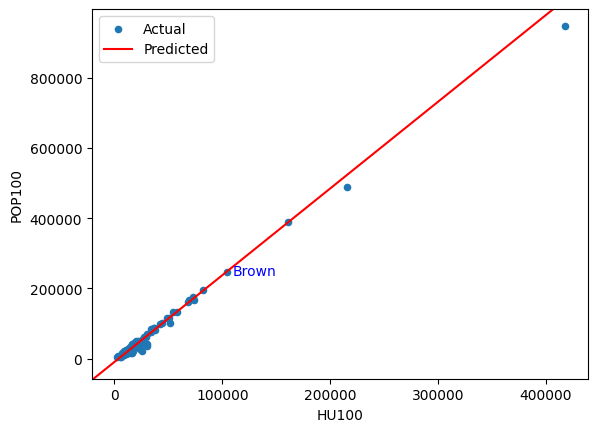

In [14]:
#Q11
brown_pop = merged_df.loc[merged_df["NAME"] == "Brown County", "POP100"].values[0]
ax = merged_df.plot.scatter(x = "HU100", y = "POP100", label = "Actual")
ax.axline((0, intercept), slope = coef, color = "red", label = "Predicted")
ax.text(x = 110000, y = brown_pop, s = "Brown", verticalalignment = "center", color = "blue")
ax.legend(frameon = True)
plt.show()

In [15]:
#Q12
A = np.array([
    [0, 0, 5, 8, 4],
    [1, 2, 4, 0, 3],
    [2, 4, 0, 9, 2],
    [3, 5, 2, 1, 1],
    [0, 5, 0, 1, 0]
])

total_elements = np.sum((A >= 3) & (A <= 6))
total_elements

8

In [16]:
c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)

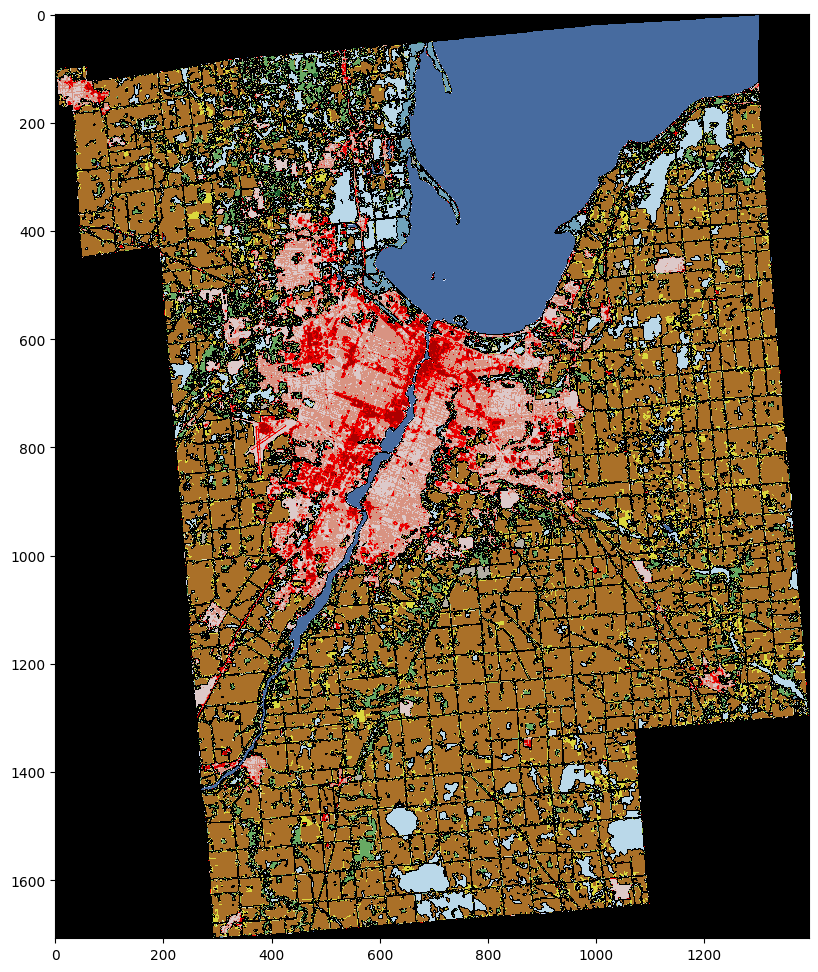

In [17]:
#Q13
land = rasterio.open("zip://../p6/land.zip!wi.tif")
brown_county = geopandas.GeoDataFrame(merged_df.set_index("NAME")["geometry"].loc[["Brown County"]])
matrix, _ = mask(land, brown_county.to_crs(land.crs)["geometry"], crop = True)
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(matrix[0], vmin=0, vmax=255, cmap = custom_cmap)

In [18]:
#Q14
land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}

brown_total_cells = np.count_nonzero(matrix)
brown_open_water = np.count_nonzero(matrix == land_use['open_water'])
brown_portion_water = brown_open_water / brown_total_cells
brown_portion_water

0.13797526789725206

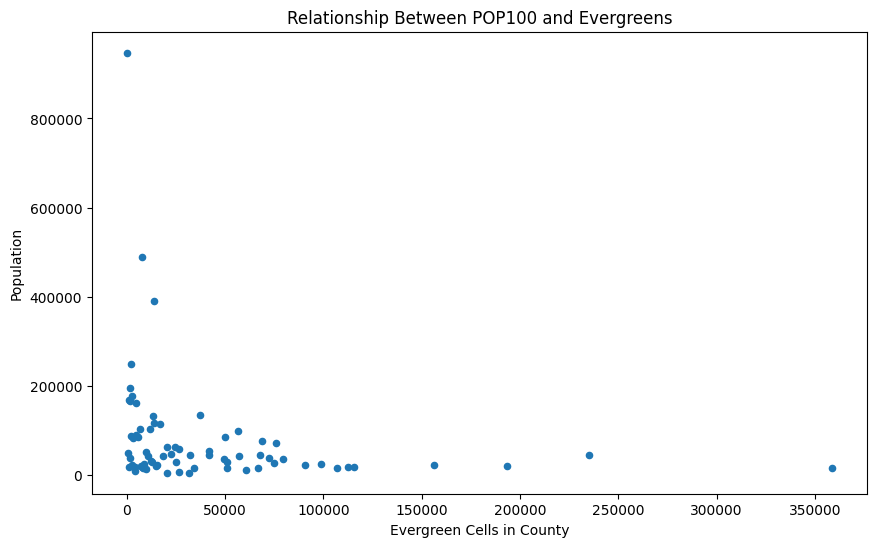

In [19]:
#Q15
crs_df = merged_df.to_crs(land.crs)

def land_type_count(county, land_type):
    matrix, _ = mask(land, crs_df[crs_df["NAME"] == county]["geometry"], crop=True)
    matrix = matrix[0]
    return (matrix == land_use[land_type]).astype(int).sum()

land_type = 'evergreen'

crs_df['count'] = crs_df['NAME'].apply(lambda county: land_type_count(county, land_type))

fig, ax = plt.subplots(figsize=(10, 6))
crs_df.plot.scatter(x = "count", y = "POP100", ax = ax, xlabel = "Evergreen Cells in County", ylabel = "Population")
plt.title("Relationship Between POP100 and Evergreens")
plt.show()


In [20]:
#Part 1
data = geopandas.read_file("tracts.shp")
data_crs = data.to_crs(land.crs)

land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}

for i in land_use.keys():
    data[i] = 0
for j, row in data_crs.iterrows():
    geometry = row["geometry"]
    matrix, _ = mask(land, [geometry], crop = True)
    matrix = matrix[0]
    for key in land_use.keys():
        data.at[j, key] = np.sum(matrix == land_use[key]).astype(int)

train, test = train_test_split(data, test_size=0.20,random_state=300)

features = list(land_use.keys())
x_train = train[features]
y_train = train["POP100"]
model = LinearRegression()
model.fit(x_train, y_train)
coef = pd.DataFrame({"Feature": features, "Coefficient": model.coef_})
coef = coef.sort_values(by = "Coefficient", ascending = False)

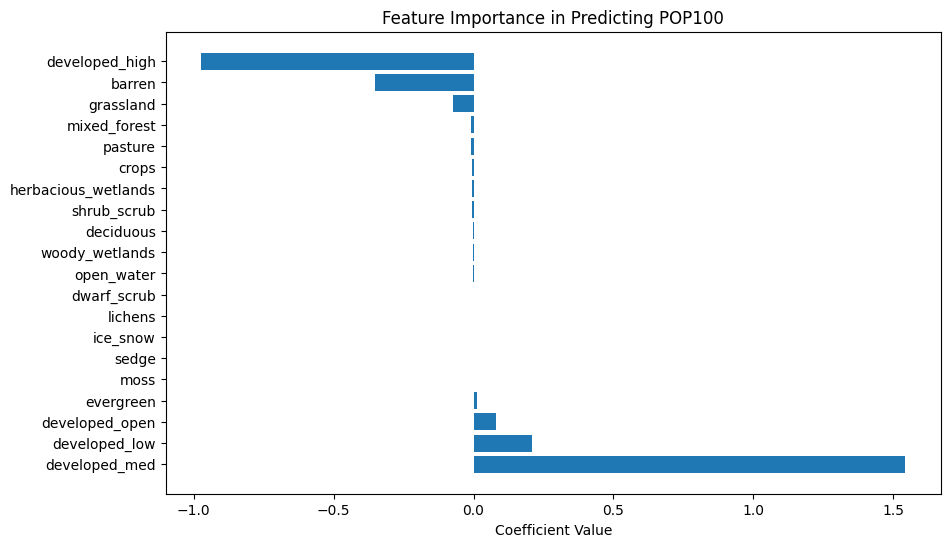

In [21]:
#Q16
plt.figure(figsize=(10, 6))
plt.barh(coef['Feature'], coef['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Predicting POP100')
plt.show()
# This bar plot is a visual display of the relationship between land feature and predicting population increases. The data shows that the higher positive coefficient values are more strongly correlated with an increase in population while the most negative values are least correlated with population growth.
# The features our model most relies on are the most positive and negative values. In this model it is developed_med and developed_high.

In [22]:
# Part 2
# polynomial regression
model_1 = Pipeline([("poly", PolynomialFeatures(degree = 2, include_bias = False)), ("lr", LinearRegression())])
score_1 = cross_val_score(model_1, train[["developed_med"]], train["POP100"]).mean()

# linear regression with multiple features
model_2 = LinearRegression()
score_2 = cross_val_score(model_2, train[["developed_med", "developed_high", "barren", "developed_low"]], train["POP100"]).mean()
score_1, score_2


(0.41543360139018776, 0.42267113135521833)

In [23]:
#Q17
# a: The mean cross validation score is high on both models but slightly higher on the linear regression with multiple features.
# b: The variance of cross validation socres is low for both models.
# c: model 1 is more complex and model 2 is more simple.
# d: Both are good models that could be used depending on situation.
# Recommendation: model 2 because of slighly higher mean of cross validation scores as well as simplicity.
model_2.fit(train[['developed_med', 'developed_high', 'barren', 'developed_low']], train["POP100"])
test_score = model_2.score(test[['developed_med', 'developed_high', 'barren', 'developed_low']], test["POP100"])
test_score

0.39487025152372424